In [686]:
import parser
import json
import urllib
import pandas as pd
import imp
import numpy as np
import seaborn as sns
import math

from sklearn.preprocessing import Imputer
from sklearn import ensemble
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.cross_validation import cross_val_score

from PIL import Image
import matplotlib.pyplot as plt
import imdb_movie_content
from collections import Counter
%matplotlib inline
imp.reload(parser)
imp.reload(imdb_movie_content)

<module 'imdb_movie_content' from '/Users/alexandreattia/Desktop/Work/Practice/HackerRankChallenge/KaggleMovieRating/imdb_movie_content.py'>

In [757]:
df = parser.create_dataframe("movie_contents.json", "movie_budget.json")
df.set_index('movie_title', inplace=True, drop=False)
df.sort_index(inplace=True)
awards_columns = [col for col in df.columns if 'nominated' in col or 'won' in col]
df_awards = df[awards_columns]
awards_per_movie = (len(awards_columns) - df_awards.isnull().sum(axis=1)).to_dict()
df['nb_awards'] = df['movie_title'].map(awards_per_movie)
df = df.drop_duplicates(['movie_title'])
df = df.rename(columns = {'director_fb_links': 'director_fb_likes'})

## Awards and Gross

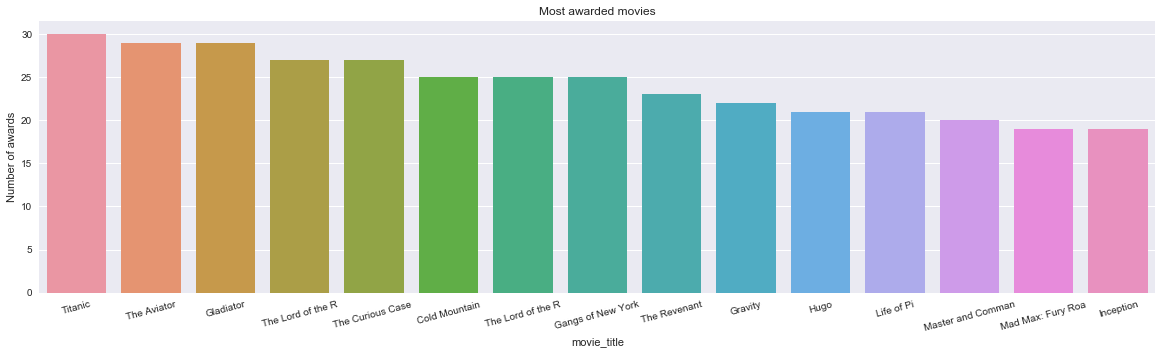

In [43]:
d = df['nb_awards'].sort_values(ascending=False)[:15]
plt.figure(figsize=(20,5))
plot = sns.barplot(x=d.index, y=d)
_ = plot.set_xticklabels([elem[:17] for elem in d.index], rotation=15)
_ = plot.set_title('Most awarded movies')
_ = plot.set_ylabel('Number of awards')

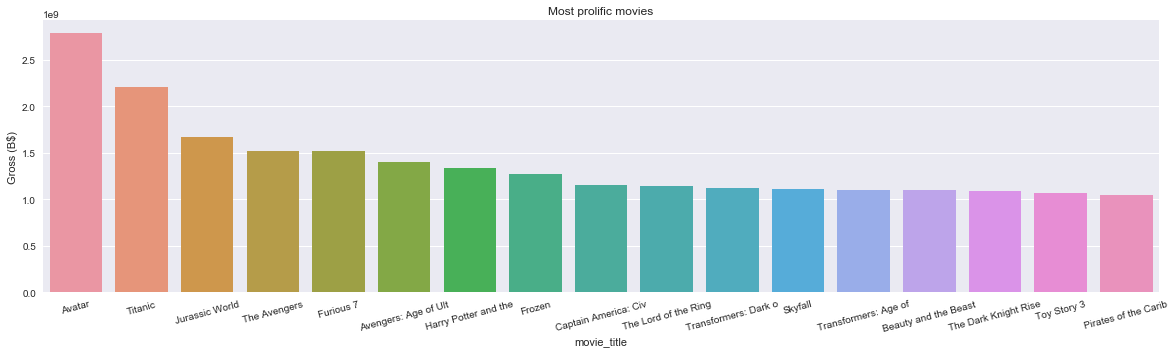

In [207]:
d = df.worldwide_gross.sort_values(ascending=False)[:17]
plt.figure(figsize=(20,5))
plot = sns.barplot(x=d.index, y=d)
_ = plot.set_xticklabels([elem[:20] for elem in d.index], rotation=15)
_ = plot.set_title('Most prolific movies')
_ = plot.set_ylabel('Gross (B$)')

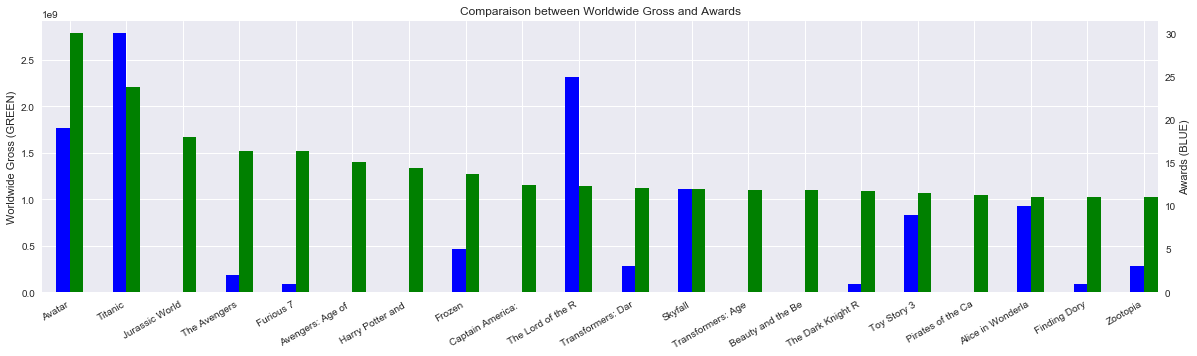

In [222]:
sns.set()

d = df.worldwide_gross.sort_values(ascending=False)[:20]
e = len(award_columns) - df_awards[df_awards.index.isin(d.index)].isnull().sum(axis=1).reindex(d.index)
margin = 0.05
width = 4*(1.-2.*margin)/15
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(111)
ax2 = ax.twinx()
d.plot(kind='bar', color='green', ax=ax, width=width, position=0)
e.plot(kind='bar', color='blue', ax=ax2, width=width, position=1)
ax.set_ylabel('Worldwide Gross (GREEN)')
ax2.set_ylabel('Awards (BLUE)')
ax.set_xlabel('')
ax.set_title('Comparaison between Worldwide Gross and Awards')
_ = ax.set_xticklabels([elem[:17] for elem in d.index], rotation = 30, ha='right')
ax2.grid(False)

## Facebook likes

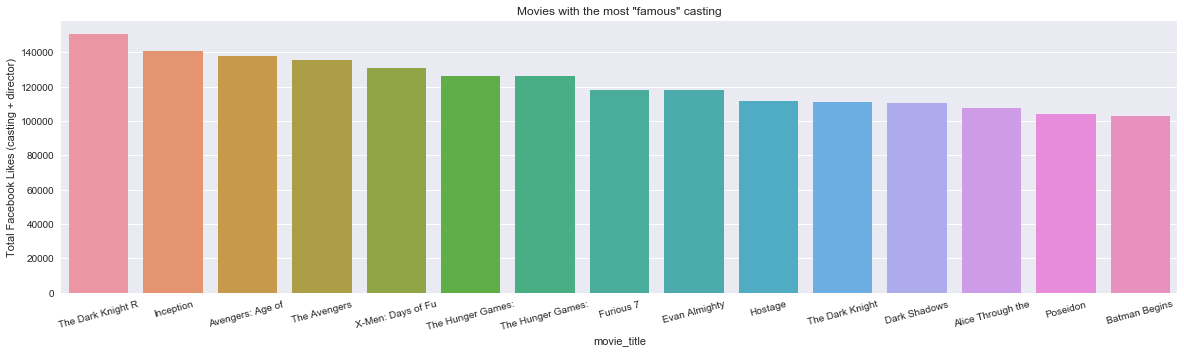

In [547]:
d = df['total_cast_fb_likes'].sort_values(ascending=False)[:15]
e = df[df.index.isin(d.index)].num_facebook_like
plt.figure(figsize=(20,5))
plot = sns.barplot(x=d.index, y=d)
_ = plot.set_xticklabels([elem[:17] for elem in d.index], rotation=15)
_ = plot.set_title('Movies with the most "famous" casting')
_ = plot.set_ylabel('Total Facebook Likes (casting + director)')

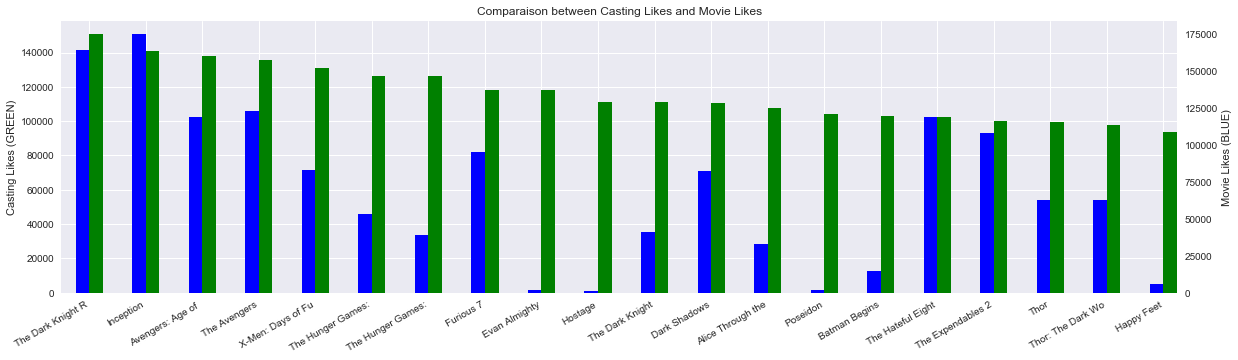

In [548]:
sns.set()

d = df['total_cast_fb_likes'].sort_values(ascending=False)[:20]
e = df[df.index.isin(d.index)].num_facebook_like.reindex(d.index)
margin = 0.05
width = 4*(1.-2.*margin)/15
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(111)
ax2 = ax.twinx()
d.plot(kind='bar', color='green', ax=ax, width=width, position=0)
e.plot(kind='bar', color='blue', ax=ax2, width=width, position=1)
ax.set_ylabel('Casting Likes (GREEN)')
ax2.set_ylabel('Movie Likes (BLUE)')
ax.set_xlabel('')
ax.set_title('Comparaison between Casting Likes and Movie Likes')
_ = ax.set_xticklabels([elem[:17] for elem in d.index], rotation = 30, ha='right')
ax2.grid(False)

## Best Actors

### Actor in movie

In [549]:
all_actors = [actor for actor in list(set(list(df.actor_1_name) + list(df.actor_2_name) + list(df.actor_3_name))) if pd.notnull(actor)]
imdb_score_per_actor = {}
for actor in all_actors:
    imdb_score_per_actor[actor] = df[(df.actor_1_name == actor) | (df.actor_2_name == actor) | (df.actor_3_name == actor)].idmb_score.mean()

In [550]:
millnames = ['',' K',' M',' B']
def millify(n):
    if pd.notnull(n):
        n = float(n)
        millidx = max(0,min(len(millnames)-1,
                            int(math.floor(0 if n == 0 else math.log10(abs(n))/3))))
        return '{:.1f}{}'.format(n / 10**(3 * millidx), millnames[millidx])
    else:
        return n

In [551]:
gross_per_actor = {}
for actor in all_actors:
    gross_per_actor[actor] = df[(df.actor_1_name == actor) | (df.actor_2_name == actor) | (df.actor_3_name == actor)].worldwide_gross.mean()

In [552]:
top_k = 10
best = [elem[0]+ ', %s (%s movie.s)' % (round(elem[1], 1),len(df[(df.actor_1_name == elem[0]) 
                                           | (df.actor_2_name == elem[0]) 
                                           | (df.actor_3_name == elem[0])])) 
        for elem in sorted(imdb_score_per_actor.items(), key=lambda x:x[1], reverse=True)][:top_k]

mini_movie = 3
best_mini = [elem[0]+ ', %s (%s movie.s)' % (round(elem[1], 1),len(df[(df.actor_1_name == elem[0]) 
                                           | (df.actor_2_name == elem[0]) 
                                           | (df.actor_3_name == elem[0])]))
        for elem in sorted(imdb_score_per_actor.items(), key=lambda x:x[1], reverse=True) if len(df[(df.actor_1_name == elem[0]) 
                                                                                                   | (df.actor_2_name == elem[0]) 
                                                                                                   | (df.actor_3_name == elem[0])]) >= mini_movie][:top_k]

best_gross_mini = [elem[0]+ ', %s$ (%s movie.s)' % (millify(elem[1]), len(df[(df.actor_1_name == elem[0]) 
                                           | (df.actor_2_name == elem[0]) 
                                           | (df.actor_3_name == elem[0])]))
        for elem in sorted(gross_per_actor.items(), key=lambda x:x[1], reverse=True) if len(df[(df.actor_1_name == elem[0]) 
                                                                                                   | (df.actor_2_name == elem[0]) 
                                                                                                   | (df.actor_3_name == elem[0])]) >= mini_movie][:top_k]
print('The {} best actors (in terms of IMDB score when they played if the movie) are : \n{}'.format(top_k,
       '\n'.join(best)))

print('\nThe {} best actors are (with minimum {} movies) : \n{}'.format(top_k, mini_movie,
       '\n'.join(best_mini)))

print('\nThe {} most prolific actors are (with minimum {} movies) : \n{}'.format(top_k, mini_movie,
       '\n'.join(best_gross_mini)))

The 10 best actors (in terms of IMDB score when they played if the movie) are : 
Laurence Fishburne, 8.7 (1 movie.s)
Mackenzie Foy, 8.6 (1 movie.s)
Robert Patrick, 8.5 (1 movie.s)
Edward Furlong, 8.5 (1 movie.s)
Tommy Flanagan, 8.5 (1 movie.s)
Joaquin Phoenix, 8.5 (1 movie.s)
Pete Docter, 8.4 (1 movie.s)
Stephen Merchant, 8.4 (1 movie.s)
Kathy Najimy, 8.4 (1 movie.s)
Edward Asner, 8.3 (1 movie.s)

The 10 best actors are (with minimum 3 movies) : 
Leonardo DiCaprio, 8.1 (9 movie.s)
Cate Blanchett, 8.1 (7 movie.s)
Tom Hanks, 7.8 (9 movie.s)
Orlando Bloom, 7.8 (7 movie.s)
Martin Freeman, 7.7 (3 movie.s)
Tom Hardy, 7.7 (6 movie.s)
Rupert Grint, 7.6 (4 movie.s)
Daniel Radcliffe, 7.6 (4 movie.s)
Zoe Saldana, 7.6 (6 movie.s)
Andy Serkis, 7.5 (3 movie.s)

The 10 most prolific actors are (with minimum 3 movies) : 
Rupert Grint, 876.9 M$ (4 movie.s)
Richard Armitage, 825.8 M$ (4 movie.s)
Michelle Rodriguez, 744.7 M$ (6 movie.s)
Robert Downey Jr., 685.7 M$ (9 movie.s)
Orlando Bloom, 682.8 M$ (7 m

### First star in movie

In [553]:
big_star = df.groupby(['actor_1_name'])['idmb_score', 'worldwide_gross'].mean().sort_values(['idmb_score', 'worldwide_gross'], ascending=False)
big_star['nb_movies'] = big_star.index
big_star['nb_movies'] = big_star['nb_movies'].map(df.groupby(['actor_1_name'])['movie_title'].count().to_dict())
big_star['worldwide_gross'] = big_star['worldwide_gross'].apply(millify)
top_k = 7
print('The {} best actors as most famous actor are :'.format(top_k))
big_star[big_star.nb_movies >= 3].head(top_k)

The 7 best actors as most famous actor are :


,idmb_score,worldwide_gross,nb_movies
actor_1_name,,,
Leonardo DiCaprio,8.122222,398.5 M,9
Matthew McConaughey,7.800000,255.5 M,3
Tom Hanks,7.787500,411.4 M,8
Richard Armitage,7.733333,977.5 M,3
Christopher Lee,7.475000,557.7 M,4
Daniel Craig,7.400000,422.9 M,4
Tom Hardy,7.350000,403.9 M,4


In [521]:
big_star = df.groupby(['actor_1_name'])['idmb_score', 'worldwide_gross'].mean().sort_values(['worldwide_gross', 'idmb_score'], ascending=False)
big_star['nb_movies'] = big_star.index
big_star['nb_movies'] = big_star['nb_movies'].map(df.groupby(['actor_1_name'])['movie_title'].count().to_dict())
big_star['worldwide_gross'] = big_star['worldwide_gross'].apply(millify)
top_k = 7
print('The {} most prolific actors as most famous actor are :'.format(top_k))
big_star[big_star.nb_movies >= 3].head(top_k)

The 7 most prolific actors as most famous actor are :


,idmb_score,worldwide_gross,nb_movies
actor_1_name,,,
Richard Armitage,7.733333,977.5 M,3
Robert Pattinson,5.675000,763.5 M,4
Chris Hemsworth,7.083333,751.6 M,6
Jennifer Lawrence,7.200000,621.7 M,8
J.K. Simmons,6.925000,605.8 M,8
Angelina Jolie,7.075000,586.5 M,4
Henry Cavill,6.600000,582.6 M,3


## IMDB rating and other variables

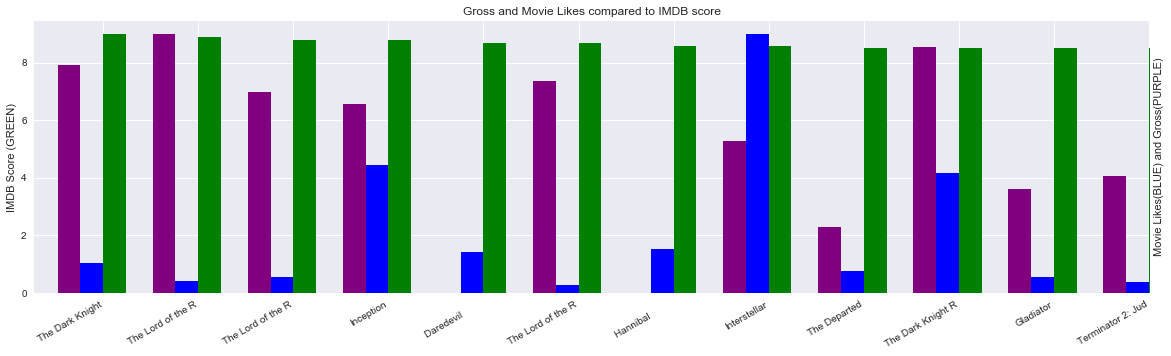

In [249]:
d = df['idmb_score'].apply(float).sort_values(ascending=False)[:12]
e = df[df.index.isin(d.index)].num_facebook_like.reindex(d.index)
f = df[df.index.isin(d.index)].worldwide_gross.reindex(d.index)
margin = 0.05
width = 4*(1.-2.*margin)/15
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(111)
ax2 = ax.twinx()
ax3= ax2.twinx()
d.plot(kind='bar', color='green', ax=ax, width=width, position=0)
e.plot(kind='bar', color='blue', ax=ax2, width=width, position=1)
f.plot(kind='bar', color='purple', ax=ax3, width=width, position=2)
ax.set_ylabel('IMDB Score (GREEN)')
ax2.set_ylabel('Movie Likes(BLUE) and Gross(PURPLE)')
ax3.set_yticklabels('')
ax2.set_yticklabels('')
ax.set_xlabel('')
_ = ax.set_xticklabels([elem[:17] for elem in d.index], rotation = 30, ha='right')
ax3.grid(False)
ax2.grid(False)
ax.set_title('Gross and Movie Likes compared to IMDB score')

,nb_awards,domestic_gross,worldwide_gross,total_cast_fb_likes,director_fb_links,production_budget,num_critic_for_reviews,idmb_score,actor_1_fb_likes,actor_2_fb_likes,actor_3_fb_likes
nb_awards,1.000000,0.310824,0.296504,0.201413,0.330924,0.124665,0.261419,0.438619,0.099267,0.164850,0.161610
domestic_gross,0.310824,1.000000,0.932742,0.321610,0.136603,0.573101,0.511014,0.401685,0.093506,0.268073,0.313035
worldwide_gross,0.296504,0.932742,1.000000,0.323085,0.125408,0.665610,0.543244,0.380624,0.079372,0.271698,0.335189
total_cast_fb_likes,0.201413,0.321610,0.323085,1.000000,0.374588,0.334847,0.444321,0.290197,0.771958,0.818460,0.819882
director_fb_links,0.330924,0.136603,0.125408,0.374588,1.000000,0.075116,0.281820,0.313780,0.137243,0.171130,0.230345
production_budget,0.124665,0.573101,0.665610,0.334847,0.075116,1.000000,0.557287,0.189417,0.164211,0.246125,0.306492
num_critic_for_reviews,0.261419,0.511014,0.543244,0.444321,0.281820,0.557287,1.000000,0.398889,0.211142,0.392141,0.412039
idmb_score,0.438619,0.401685,0.380624,0.290197,0.313780,0.189417,0.398889,1.000000,0.151905,0.229136,0.247351
actor_1_fb_likes,0.099267,0.093506,0.079372,0.771958,0.137243,0.164211,0.211142,0.151905,1.000000,0.540777,0.412211
actor_2_fb_likes,0.164850,0.268073,0.271698,0.818460,0.171130,0.246125,0.392141,0.229136,0.540777,1.000000,0.796064


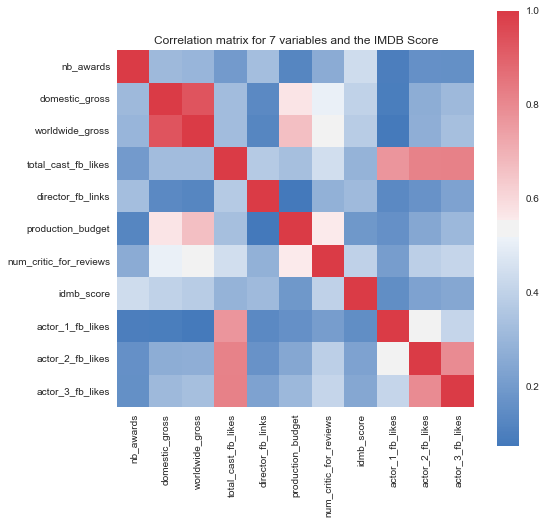

In [536]:
# Correlation Matrix

corr = df[['nb_awards', 'domestic_gross','worldwide_gross', 
    'total_cast_fb_likes','director_fb_links', 'production_budget',
    'num_critic_for_reviews', 'idmb_score', 'actor_1_fb_likes', 'actor_2_fb_likes', 'actor_3_fb_likes']].corr()

plt.figure(figsize=(8,8))
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(250, 10, as_cmap=True),
            square=True)
plt.title('Correlation matrix for 7 variables and the IMDB Score')
corr

## Genres

In [537]:
with open('genre.json', 'r') as f:
    genres = json.load(f)

In [538]:
imdb_score_per_genre = {}
gross_per_genre = {}
genre_columns = [col for col in df.columns if 'genre_' in col]
df_genres = df[genre_columns]
for genre, value in genres.items():
    mask = np.column_stack([df_genres[col] == value for col in df_genres])
    df_specific_genre = df.loc[mask.any(axis=1)][['genres', 'idmb_score', 'worldwide_gross']]
    imdb_score_per_genre[genre] = df_specific_genre.idmb_score.mean()
    gross_per_genre[genre] = df_specific_genre.worldwide_gross.mean()
gross_per_genre = {k:v for k,v in gross_per_genre.items() if pd.notnull(v)}

In [539]:
top_k = 5
print('The {} best genres (in terms of IMDB score) are : \n{}'.format(top_k, 
       '\n'.join(['%s (%s)' % (elem[0], round(elem[1], 1)) for elem in sorted(imdb_score_per_genre.items(), key=lambda x:x[1], reverse=True)][:top_k])))

print('\nThe {} most prolific genres are  : \n{}'.format(top_k, 
       '\n'.join(['%s (%s)' % (elem[0], millify(elem[1])) for elem in sorted(gross_per_genre.items(), key=lambda x:x[1], reverse=True)][:top_k])))

The 5 best genres (in terms of IMDB score) are : 
Biography (7.2)
Drama (7.0)
History (7.0)
Mystery (7.0)
War (6.9)

The 5 most prolific genres are  : 
Musical (470.1 M)
Fantasy (457.9 M)
Adventure (454.1 M)
Animation (440.4 M)
Family (426.2 M)


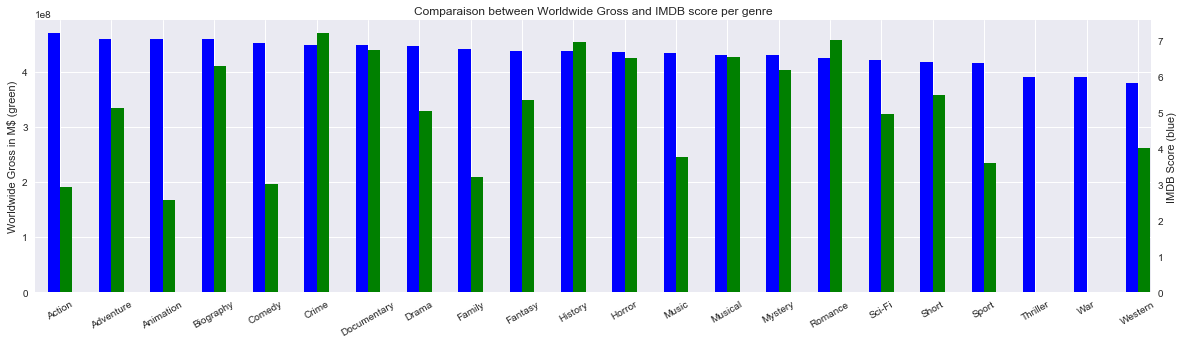

In [546]:
margin = 0.05
width = 4*(1.-2.*margin)/15
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(111)
ax2 = ax.twinx()

df_combine = pd.concat([pd.Series(gross_per_genre), pd.Series(imdb_score_per_genre)], axis=1)
df_combine = df_combine.sort_values(1, ascending=False)
df_combine.columns = ['Gross', 'Score']

df_combine.Gross.plot(kind='bar', color='green', ax=ax, width=width, position=0)
df_combine.Score.plot(kind='bar', color='blue', ax=ax2, width=width, position=1)
ax.set_ylabel('Worldwide Gross in M$ (green)')
ax2.set_ylabel('IMDB Score (blue)')
ax.set_xlabel('')
ax.set_title('Comparaison between Worldwide Gross and IMDB score per genre')
_ = ax.set_xticklabels(pd.Series(imdb_score_per_genre).index, rotation = 30)
ax2.grid(False)

## Prediction

### Preprocessing

In [758]:
## Fill NA for genres
df.genres  = df.genres.fillna('')

## Mean Inputer
col_to_impute = ['actor_1_fb_likes', 'actor_2_fb_likes', 'actor_3_fb_likes',
                'domestic_gross', 'duration_sec', 'num_critic_for_reviews', 'num_facebook_like', 'num_user_for_reviews',
                'production_budget', 'total_cast_fb_likes', 'worldwide_gross', 'director_fb_likes']
for col in col_to_impute:
    column = np.array(df[col]).reshape(1, -1)
    imp = Imputer(missing_values='NaN', strategy='mean', axis=1)
    df[col] = imp.fit_transform(column)[0]

In [759]:
numerical_cols = list(df.dtypes[df.dtypes != 'object'].index)
not_wanted_cols = ['title_year', 'storyline', 'release_date', 'image_urls', 'movie_title', 'keywords', 'movie_imdb_link', 'num_voted_users'] + genre_columns
df.country = df.country.apply(lambda x:x.split('|'))
df.language = df.language.apply(lambda x:x.split('|'))
list_cols = ['country', 'genres', 'language']
cols_to_transform = [cols for cols in df.columns if cols not in numerical_cols + not_wanted_cols + list_cols]
df2 = df[cols_to_transform]

In [760]:
## Dummies for columns with list
df_col_list = pd.DataFrame()
for col in list_cols:
    df_col_list = pd.concat([df_col_list, pd.get_dummies(df[col].apply(pd.Series).stack()).sum(level=0)], axis=1)

In [761]:
## Dummies for columns with string
df_col_string = pd.get_dummies(df2, columns=cols_to_transform)

In [762]:
X_raw = pd.concat([df[numerical_cols], df_col_string, df_col_list], axis=1)
print('Columns dtypes :', Counter(X_raw.dtypes))

Columns dtypes : Counter({dtype('uint8'): 3932, dtype('float64'): 13, dtype('int64'): 1})


In [776]:
y = list(X_raw.idmb_score)
X = X_raw.drop('idmb_score', axis=1)

In [777]:
X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(
    X, y, test_size=0.20, random_state=42)
print('Train', X_train.shape, 'Test', X_test.shape)

Train (1011, 3945) Test (253, 3945)


### Learning

In [683]:
gbr = ensemble.GradientBoostingRegressor(n_estimators=2000)
gbr.fit(X_train,Y_train)
print ("Training Score GradientBoosting: ", str(gbr.score(X_train,Y_train)))
print ("Test Score GradientBoosting: " , str(gbr.score(X_test,Y_test)))

Training Score GradientBoosting:  0.992207293823
Test Score GradientBoosting:  0.419250141323


In [696]:
gbr = ensemble.GradientBoostingRegressor(n_estimators=1000)
gbr.fit(X_train,Y_train)
print ("Training Score GradientBoosting: ", str(gbr.score(X_train,Y_train)))
print ("Test Score GradientBoosting: " , str(gbr.score(X_test,Y_test)))

Training Score GradientBoosting:  0.965677058186
Test Score GradientBoosting:  0.445847202544


In [748]:
abr = ensemble.AdaBoostRegressor(n_estimators=10, learning_rate=0.4, loss='linear')
abr.fit(X_train,Y_train)
print ("Training Score AdaBoostRegressor: ", str(abr.score(X_train,Y_train)))
print ("Test Score AdaBoostRegressor: " , str(abr.score(X_test,Y_test)))

Training Score AdaBoostRegressor:  0.497750738605
Test Score AdaBoostRegressor:  0.450030379927


In [685]:
rf=ensemble.RandomForestRegressor(n_estimators=30,oob_score=True)
rf.fit(X,y)
print ("Training Score RandomForest: ", str(rf.score(X,y)))
print ("OOB Score RandomForest: " , str(rf.oob_score_))

Training Score RandomForest:  0.928940620993
OOB Score RandomForest:  0.484230957161


In [765]:
rf=ensemble.RandomForestRegressor(n_estimators=500,oob_score=True, ) 
rf.fit(X,y)
print ("Training Score RandomForest: ", str(rf.score(X,y)))
print ("Cross Validation (10 fold) Score: " , np.mean(cross_val_score(rf, X_train, Y_train, cv=10)))

Training Score RandomForest:  0.933556405649
OOB Score RandomForest:  0.514455022206


In [769]:
rf=ensemble.RandomForestRegressor(n_estimators=1000, oob_score=True) 
rf.fit(X,y)
print ("Training Score RandomForest: ", str(rf.score(X,y)))
print ("OOB Score RandomForest: " , str(rf.oob_score_))

Training Score RandomForest:  0.934778324128
OOB Score RandomForest:  0.515648202539


### Cross Validation to choose n_estimators

In [780]:
for k in [1500, 2000, 2500, 3000]:
    rf=ensemble.RandomForestRegressor(n_estimators=k, oob_score=True) 
    rf.fit(X,y)
    rfs[k] = np.mean(cross_val_score(rf, X_train, Y_train, cv=5))

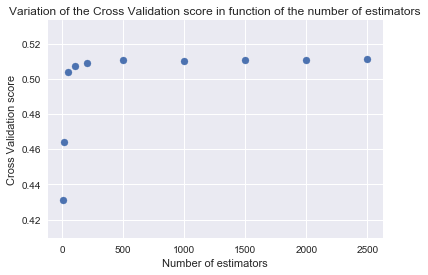

In [812]:
x_plot = list(rfs.keys())
y_plot = list(rfs.values())

f, ax = plt.subplots()
ax.scatter(x_plot, y_plot)
ax.set_title('Variation of the Cross Validation score in function of the number of estimators')
ax.set_xlabel('Number of estimators')
ax.set_ylabel('Cross Validation score')

### Most important features

In [728]:
top_k = 5
best = zip(X_train.columns[np.argsort(rf.feature_importances_)[::-1][:top_k]], np.sort(rf.feature_importances_)[::-1][:top_k])
print('The {} most important features are :\n{}'.format(top_k,
                                            '\n'.join([elem[0] + ', %.3f' % elem[1] for elem in best])))

The 5 most important features are :
nb_awards, 0.247
num_facebook_like, 0.194
duration_sec, 0.075
num_critic_for_reviews, 0.054
num_user_for_reviews, 0.043


In [473]:
## TO DO 
# 0. Download movie contents for movie budgets 2
# 1. Combine all movie-budgets DONE ! 
# 2. Combine downloaded movie content(2,3,4 already combined : 800 elem, miss 5)
# 3. Download movie contents

In [821]:
with open('movie_contents.json', 'r') as fp:
    movies = json.load(fp)
with open('movie_contents8.json', 'r') as fp:
    movies2 = json.load(fp)

In [822]:
len(movies), len(movies2), len([mov for mov in movies2 if mov not in movies])

(1595, 200, 0)

In [819]:
m = movies + [mov for mov in movies2 if mov not in movies]
len(m)

1595

In [820]:
with open('movie_contents.json', 'w') as fp:
    json.dump(m, fp)